In [40]:
import trimesh
import numpy as np
from numba import cuda
import math
import matplotlib.pyplot as plt
from numba.core.errors import NumbaPerformanceWarning
import warnings
warnings.simplefilter('ignore', category=NumbaPerformanceWarning)
cuda.select_device(0)
stream = cuda.stream()

In [41]:
#plot sparseArrays to output function def makeImage(sparse_array_to_plot, sparse_img_coords, fn, subtractMin = False):

@cuda.jit
def get_max(result, values):
    idx = cuda.grid(1)
    nrows = values.shape[0]
    if idx < nrows:
        cuda.atomic.max(result, 0, values[idx])

@cuda.jit
def get_min(result, values):
    idx = cuda.grid(1)
    nrows = values.shape[0]
    if idx < nrows:
        cuda.atomic.min(result, 0, values[idx])

@cuda.jit(device=False)
def normTo255(out_array,array, min, max):
    idx = cuda.grid(1)
    nrows = array.shape[0]
    if idx < nrows:
        out_array[idx] = int((array[idx]-min)/max*255)#int((array[idx])/max*255)#

@cuda.jit(device=False)
def sparse_to_img(out_image, sparseArray, sparse_img_coords):
    idx = cuda.grid(1)
    nrows = sparseArray.shape[0]
    if idx < nrows:
        px, py = (sparse_img_coords[idx,0], sparse_img_coords[idx,1])
        out_image[px,py] = math.floor(sparseArray[idx])

def makeImage(sparse_array_to_plot, sparse_img_coords, fn, subtractMin = False):
    d_out_img = cuda.device_array((int(voxel_bounds[0]),int(voxel_bounds[1])), np.uint8) # final slicer image
    d_sparse_scaled = cuda.device_array(int(sparse_array_to_plot.shape[0]), dtype=np.float32) 

    threadsperblock = (32, 32) 
    blockspergrid_x = math.ceil(d_out_img.shape[0] / threadsperblock[0])
    blockspergrid_y = math.ceil(d_out_img.shape[1] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)
    initMatrix[blockspergrid, threadsperblock](d_out_img,0) #init matrix on GPU

    result = np.zeros(1, dtype=np.float64)
    threadsperblock = 128 # max for rtx2070
    blockspergrid = (sparse_array_to_plot.shape[0] + (threadsperblock - 1)) // threadsperblock
    get_max[blockspergrid,threadsperblock](result, sparse_array_to_plot)
    array_max = result[0]
    get_min[blockspergrid,threadsperblock](result, sparse_array_to_plot)
    array_min = result[0]
    print(array_min, array_max)
    
    threadsperblock = 128 #1024 # max for rtx2070
    blockspergrid = (d_sparse_scaled.shape[0] + (threadsperblock - 1)) // threadsperblock
    if (subtractMin):
        normTo255[blockspergrid, threadsperblock](d_sparse_scaled, sparse_array_to_plot, array_min, array_max)
    else:
        normTo255[blockspergrid, threadsperblock](d_sparse_scaled, sparse_array_to_plot, 0, array_max)

    threadsperblock = 128 #1024 # max for rtx2070
    blockspergrid = (sparse_array_to_plot.shape[0] + (threadsperblock - 1)) // threadsperblock
    sparse_to_img[blockspergrid, threadsperblock](d_out_img, d_sparse_scaled, sparse_img_coords)
    out_img = d_out_img.copy_to_host(stream=stream)
    stream.synchronize()
    plt.imsave(fname=fn, arr=out_img, cmap='gray_r', format='png')

In [42]:
filepath = 'C:/Resin/articulated-dragon-mcgybeer20211115-748-6f8p9f/mcgybeer/articulated-dragon-mcgybeer/Dragon_v2/' #'C:/VSCode/PythonTest/' #
filename = 'Dragon_v2.stl' #'test.stl'# 'cube.stl'#
mesh_raw = trimesh.load_mesh(filepath + filename, validate=True)
origin, xaxis, yaxis, zaxis = [0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1]
# give it a color
mesh_raw.visual.face_colors = [100, 100, 100, 255]
# and show it
# mesh_raw.show(viewer='gl')

[960, 1224, 282]
None


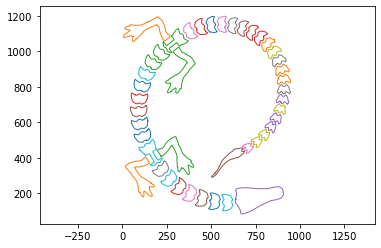

In [44]:
origin, xaxis, yaxis, zaxis = [0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1]
mesh = mesh_raw.copy()
transform, bounds = trimesh.bounds.oriented_bounds(mesh, angle_digits=1, ordered=False, normal=zaxis)
#mesh.apply_transform(trimesh.transformations.reflection_matrix(bounds/2.0, zaxis)) 
scale_rel_to_buildplate = 0.4
scale = min([3840.0,2400.0,4000.0]/bounds)*scale_rel_to_buildplate # min([10,10,10]/bounds) #
# voxel_bounds = scale*bounds
# voxel_bounds = np.ceil(voxel_bounds)
mesh.apply_transform(transform)
mesh.apply_transform(trimesh.transformations.translation_matrix(bounds/2.0))
mesh.apply_transform(trimesh.transformations.scale_matrix(scale, origin))
# Rz = trimesh.transformations.rotation_matrix(math.pi/2.0, zaxis)
# mesh.apply_transform(Rz)
mesh.rezero()
# print(voxel_bounds)
# print(mesh.bounding_box.bounds)
voxel_bounds = [int(np.ceil(mesh.bounding_box.bounds[1,0])), int(np.ceil(mesh.bounding_box.bounds[1,1])), int(np.ceil(mesh.bounding_box.bounds[1,2]))]
print(voxel_bounds)
voxel_bounds[0] += 5 # 2px left 3px right border
voxel_bounds[1] += 5 
voxel_bounds[0] += voxel_bounds[0] % 2
voxel_bounds[1] += voxel_bounds[1] % 2
mesh.apply_transform(trimesh.transformations.translation_matrix([2.5,2.5,0])) # shift xy by half a pixel (+2px Boder), so pixel index coordinate is mid pixel
z_layer = 5
project_z0_matrix = [[1,0,0,0],[0,1,0,0],[0,0,1,-z_layer],[0,0,0,1]]
slice = mesh.section(plane_origin=[0,0,z_layer], plane_normal=zaxis)
slice_2D, to_3D = slice.to_planar(to_2D=project_z0_matrix, normal=zaxis, check=False)
print(slice_2D.plot_entities())

# sparseImg = np.nonzero(binaryImg)
# sparseImg = np.transpose([sparseImg[1],sparseImg[0]])

/* use CUDA to calc on mesh*/

In [8]:
#CUDA scan array (np.cumsum)
# parallel_prefix_sum on CUDA (=np.cumsum). Its needed to pick values from an array
scan_max_threads = 1024
scan_array_size = scan_max_threads*2
scan_nlevel = int(math.log2(scan_array_size))

@cuda.jit(device=True)
def exclusiv_parallel_prefix_sum(array, idx, nrows):
    #nrows = s_array.shape[0]
    #Up-Sweep - beware changes cause idx already has factor 2 in it
    for d in range(scan_nlevel):
        two_pow_d = 2**d
        k = idx*two_pow_d - 1
        kidx = k + 2**(d+1)
        if (kidx < nrows): 
            array[kidx] += array[k + two_pow_d]
        cuda.syncthreads() # Wait until all threads have completed up sweep 
    #down sweep
    array[nrows-1] = 0
    for d in range(scan_nlevel-1,-1,-1):
        two_pow_d = 2**d
        k = idx*two_pow_d - 1
        kidx = k + 2**(d+1)
        if (kidx < nrows): 
            t = array[k + two_pow_d]
            array[k + two_pow_d] = array[kidx]
            array[kidx] +=  t
        cuda.syncthreads() # Wait until all threads have completed down sweep 
        
@cuda.jit(device=False)
def scan_preScan(array):
    threadID = cuda.threadIdx.x
    blockID = cuda.blockIdx.x # Block id in a 1D grid

    idx_shared = threadID*2 # index in shared array 
    idx_device = idx_shared + blockID*scan_array_size # index in full array
    nrows = array.shape[0] - 1 # index limit for last block
    
    # Preload data into shared memory
    s_array = cuda.shared.array(shape=(scan_array_size), dtype=array.dtype) 
    if (idx_device < nrows): # each thread handles 2 fields
        s_array[idx_shared] = array[idx_device]
        s_array[idx_shared + 1] = array[idx_device + 1] 
    cuda.syncthreads()  # Wait until all threads finish preloading

    exclusiv_parallel_prefix_sum(s_array, idx_shared, scan_array_size) # scan s_array
    
    # output for exclusiv scan
    # if (idx2 < nrows):
    #   array[idx2] = s_array[idx]
    #   array[idx2 + 1] = s_array[idx + 1] 
    # output for inclusiv scan: switch the exclisiv scan to an inclusiv scan by shifting left and adding at the end
    if (idx_shared + 2 == scan_array_size or idx_device + 1 == nrows): # last index in s_array or last index in array
        array[idx_device] = s_array[idx_shared + 1]
        array[idx_device + 1] += s_array[idx_shared + 1]
    elif (idx_device < nrows):
        array[idx_device] = s_array[idx_shared + 1]
        array[idx_device + 1] = s_array[idx_shared + 2] 

@cuda.jit(device=False)
def scan_addTwoBlocks(array):
    threadID = cuda.threadIdx.x*2 + scan_array_size
    nrows = array.shape[0]
    if (threadID < nrows):
        array[threadID] += array[scan_array_size-1]
        array[threadID+1] += array[scan_array_size-1]

@cuda.jit(device=False)
def scan_addNBlocksOnDevice(array, nsum):
    threadID = cuda.threadIdx.x*2
    threadID2 = threadID + 1
    
    s_array = cuda.shared.array(shape=(scan_array_size), dtype=array.dtype) # create and copy data to block-sum-array
    cuda.syncthreads() # needed?
    
    pp1 = (threadID + 1)*scan_array_size - 1
    pp2 = (threadID2 + 1)*scan_array_size - 1
    if (pp1 < array.shape[0]):
        s_array[threadID] = array[pp1] # copy end of blocks from pre-scan
    if (pp2 < array.shape[0]):
        s_array[threadID2] = array[pp2] # copy end of blocks from pre-scan
    cuda.syncthreads()

    exclusiv_parallel_prefix_sum(s_array, threadID, nsum + nsum%2) # scan s_array, need to be even

    # add sums to d_array. Is one block fast or better to copy s_array to multiple blocks?
    for i in range(1,nsum): #first block need no addition
        pp1=threadID*nsum
        if (pp1 < array.shape[0]):
            array[pp1] += s_array[i] # copy end of blocks from pre-scan
        pp2=threadID2*nsum
        if (pp2 < array.shape[0]):
            array[pp2] += s_array[i] # copy end of blocks from pre-scan
    
    # nrows = d_block_sum.shape[0]
    # if (d_block_sum < nrows):
    #     d_block_sum[threadID] = d_array[threadID*(array_size-1)]

@cuda.jit(device=False)
def scan_copyBlockEnds(array, block_sum):
    idx = cuda.grid(1)
    idx2 = (idx + 1)*scan_array_size - 1

    idx_limit = block_sum.shape[0]
    idx2_limit = array.shape[0]
    if (idx < idx_limit):
        if (idx2 < idx2_limit): # exlude the extra to make it even
            block_sum[idx] = array[idx2]
        else:
            block_sum[idx] = array[idx2_limit - 1] # copy last element

@cuda.jit(device=False)
def scan_addBlockEnds(array, block_sum):
    idx = cuda.grid(1)
    idx2 = int(math.floor(cuda.blockIdx.x/2)) - 1 # add sum from previous block
    idx_limit = array.shape[0]
    idx2_limit = block_sum.shape[0]
    if (idx < idx_limit and 0 <= idx2 and idx2 < idx2_limit):
        array[idx] += block_sum[idx2]


#TODO: make this work for arbetrary mani levels (recursiv structure) and test with small scan_max_threads
def scan_array(arr):
    if (arr.shape[0] % 2 == 1):
        print("array not even!")
        return

    prescan_blockspergrid = (math.ceil(arr.shape[0]/2.0) + (scan_max_threads - 1)) // scan_max_threads
    scan_preScan[prescan_blockspergrid, scan_max_threads](arr) # scans blocks of length max_threads*2

    # 1 Block -> allready done
    if prescan_blockspergrid == 1:
        pass
    elif (prescan_blockspergrid == 2): # 2 Blocks -> just add end of block 1 to second block
        scan_addTwoBlocks[1, scan_max_threads](arr)
    elif (prescan_blockspergrid <= scan_array_size): #write end of block directly to shared array and scan
        d_block_sum = cuda.device_array(prescan_blockspergrid + prescan_blockspergrid%2, np.uint32) # needs to be even
        threadsperblock = min(scan_max_threads, d_block_sum.shape[0])
        blockspergrid = (d_block_sum.shape[0] + (threadsperblock - 1)) // threadsperblock
        scan_copyBlockEnds[blockspergrid, threadsperblock](arr, d_block_sum) # copy end of all blocks
        scan_preScan[1, scan_max_threads](d_block_sum) # only one block so prescan = full scan
        threadsperblock = scan_max_threads
        blockspergrid = (arr.shape[0] + (threadsperblock - 1)) // threadsperblock
        scan_addBlockEnds[blockspergrid, threadsperblock](arr, d_block_sum)
    else: # d_block_sum doesnt fit in array_size, expand one level, currently no need to go further.
        # print("prescan_blockspergrid > array_size!")
        threadsperblock = scan_max_threads
        d_block_sum = cuda.device_array(prescan_blockspergrid + prescan_blockspergrid%2, np.uint32) # needs to be even
        blockspergrid = (d_block_sum.shape[0] + (threadsperblock - 1)) // threadsperblock
        scan_copyBlockEnds[blockspergrid, threadsperblock](arr, d_block_sum) # copy end of all blocks
        threadsperblock = scan_max_threads #1024 # max for rtx2070
        sum_prescan_blockspergrid = (math.ceil(d_block_sum.shape[0]/2.0) + (scan_max_threads - 1)) // scan_max_threads
        scan_preScan[sum_prescan_blockspergrid, threadsperblock](d_block_sum) # only one block so prescan = full scan
        if (sum_prescan_blockspergrid == 2): #cant be one. TODO Merge with  elif (prescan_blockspergrid <= scan_array_size):
            scan_addTwoBlocks[1, scan_max_threads](d_block_sum)
        else:
            #block block sum
            threadsperblock = scan_max_threads
            d_block_block_sum = cuda.device_array(sum_prescan_blockspergrid + sum_prescan_blockspergrid%2, np.uint32) # needs to be even
            blockspergrid = (d_block_block_sum.shape[0] + (threadsperblock - 1)) // threadsperblock
            scan_copyBlockEnds[blockspergrid, threadsperblock](d_block_sum, d_block_block_sum) # copy end of all blocks
            threadsperblock = scan_max_threads
            blockspergrid = 1
            scan_preScan[blockspergrid, threadsperblock](d_block_block_sum) # only one block so prescan = full scan
            threadsperblock = scan_max_threads
            blockspergrid = (d_block_sum.shape[0] + (threadsperblock - 1)) // threadsperblock
            scan_addBlockEnds[blockspergrid, threadsperblock](d_block_sum, d_block_block_sum)
        threadsperblock = scan_max_threads
        blockspergrid = (arr.shape[0] + (threadsperblock - 1)) // threadsperblock
        scan_addBlockEnds[blockspergrid, threadsperblock](arr, d_block_sum)

In [9]:
#test array scan
# test with ones
# rng = np.random.default_rng(6584)
# von = 4
# bis = scan_array_size*scan_array_size*8
# for i in range (100):
#     cuda.current_context().deallocations.clear()
#     randomint = rng.integers(low=von/2, high=bis/2,size=1)[0]*2
#     testarray = np.asarray(np.ones(randomint), dtype=np.int32)
#     d_testarray = cuda.to_device(testarray)
#     scan_array(d_testarray)
#     if (d_testarray[-1] != randomint):
#         print(i, randomint, d_testarray[-1])
#         break
# #test with random numbers 0-1
# rng = np.random.default_rng(6584)
# von = 4
# bis = scan_array_size*scan_array_size*8
# for i in range (10):
#     cuda.current_context().deallocations.clear()
#     randomint = rng.integers(low=von/2, high=bis/2,size=1)[0]*2
#     testarray = np.asarray(rng.integers(low=0, high=1,size=randomint), dtype=np.int32)
#     d_testarray = cuda.to_device(testarray)
#     scan_array(d_testarray)
#     python_scan = np.cumsum(testarray)[-1]
#     if (d_testarray[-1] != python_scan):
#         print(i, randomint, d_testarray[-1])
#         break
# #test with random numbers 0-255
# rng = np.random.default_rng(6584)
# von = scan_array_size
# bis = scan_array_size*scan_array_size
# for i in range (10):
#     cuda.current_context().deallocations.clear()
#     randomint = rng.integers(low=von/2, high=bis/2,size=1)[0]*2
#     testarray = np.asarray(rng.integers(low=0, high=255,size=randomint), dtype=np.int32)
#     d_testarray = cuda.to_device(testarray)
#     scan_array(d_testarray)
#     python_scan = np.cumsum(testarray)[-1]
#     if (d_testarray[-1] != python_scan):
#         print(i, randomint, d_testarray[-1])
#         break

In [10]:
#CUDA slicing
@cuda.jit(device=False)
def initMatrix(out_matrix, val):
    idx, idy = cuda.grid(2)
    nrows = out_matrix.shape[0]
    ncolls = out_matrix.shape[1]
    if idx < nrows and idy < ncolls:
        out_matrix[idx, idy] = val

@cuda.jit(device=False)
def matrix_mod2(out_matrix):
    idx, idy = cuda.grid(2)
    nrows = out_matrix.shape[0]
    ncolls = out_matrix.shape[1]
    if idx < nrows and idy < ncolls:
        out_matrix[idx, idy] = out_matrix[idx, idy] % 2

# matrix size must be grater than path size
@cuda.jit(device=False)
def count_crossings(out_matrix, path):
    idx, idy = cuda.grid(2)
    nrows = out_matrix.shape[0]
    ncolls = out_matrix.shape[1]

    # index = cuda.threadIdx.x + (cuda.threadIdx.x + 1)*cuda.threadIdx.y
    # path_len = path.shape[0]
    # s_path = cuda.shared.array(shape=(1024,2), dtype='float32')
    # loop_count = math.ceil(path_len / 1024.0)
    # for i in range(loop_count):
    #     shifted_index = index + i*1024
    #     if (shifted_index < path_len):
    #         s_path[index] = (path[shifted_index,0],path[shifted_index,1])
    #     cuda.syncthreads()  # Wait until all threads finish preloading

    if idx < nrows and idy < ncolls:
        # out_matrix[idx, idy] += 1
        path_size_1 = path.shape[0] - 1
        for i in range(path_size_1):
            i2 = i + 1
            # fast tests
            # if (path[i, 0] > idx and path[i2, 0] > idx):
            #     continue
            if (path[i, 0] <= idx and path[i2, 0] <= idx):
                continue
            if (path[i, 1] <= idy and path[i2, 1] <= idy):
                continue
            if (path[i, 1] >= idy and path[i2, 1] >= idy):
                continue
            delta_y = (path[i2, 1] - path[i, 1])
            if (abs(delta_y) > 1e-10):
                x_cross = (idy - path[i, 1]) * (path[i2, 0] - path[i, 0]) / delta_y + path[i, 0]
                if (x_cross >= idx): # crossed the line?
                    out_matrix[idx, idy] += 1

In [11]:
# slice_2D.plot_discrete()

In [12]:
# slice
d_sliceImg = cuda.device_array((int(voxel_bounds[0]),int(voxel_bounds[1])), np.int32)
threadsperblock = (32, 32) 
blockspergrid_x = math.ceil(d_sliceImg.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(d_sliceImg.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)
initMatrix[blockspergrid, threadsperblock](d_sliceImg, 0)

for i in range(slice_2D.polygons_closed.shape[0]):
    if slice_2D.polygons_closed[i] is not None:
        h_path = np.asarray(list(slice_2D.polygons_closed[i].exterior.coords), dtype=np.float64)
        d_path = cuda.to_device(h_path)
        count_crossings[blockspergrid, threadsperblock](d_sliceImg, d_path)

matrix_mod2[blockspergrid, threadsperblock](d_sliceImg)
out_img = d_sliceImg.copy_to_host(stream=stream)
stream.synchronize()
plt.imsave(fname='custom_slice.png', arr=out_img, cmap='gray_r', format='png')

In [13]:
#CUDA slice to sparse
@cuda.jit(device=False)
def get_limit(some_array, out_limit):
    out_limit[0] = some_array[some_array.shape[0] - 1]

@cuda.jit(device=False)
def sliceImg_to_sparseImg(sliceImg, sparseImg, blocklength):
    idx = cuda.grid(1)
    nrows = sliceImg.shape[0]
    if (idx == 0 and sliceImg[0] == 1): # first case extra cause idx-1 in elif bellow
        sparseImg[0] = (0, 0)
    elif idx < nrows:
        if (sliceImg[idx-1] < sliceImg[idx]): # select only on step up
            sparse_pixel_number = sliceImg[idx] - 1 # shift by 1 cause inclusiv sum
            sparseImg[sparse_pixel_number] = (int(math.floor(idx / blocklength)), idx % blocklength)

@cuda.jit(device=False)
def sparsePixel_to_img(out_image, sparsePixels):
    idx = cuda.grid(1)
    nrows = sparsePixels.shape[0]
    if idx < nrows:
        px, py = (sparsePixels[idx,0], sparsePixels[idx,1])
        out_image[px,py] = 1

In [14]:
#convert to sparse form
d_sliceImg = d_sliceImg.reshape(d_sliceImg.shape[0]*d_sliceImg.shape[1])
scan_array(d_sliceImg)
d_sliceImg_scan_limit = cuda.device_array(1, d_sliceImg.dtype)
# d_sliceImg = d_sliceImg.reshape((int(voxel_bounds[0]),int(voxel_bounds[1]))) # better to discard cause of large int32
get_limit[1, 1](d_sliceImg, d_sliceImg_scan_limit)
slice_img_scan_limit = int(d_sliceImg_scan_limit.copy_to_host(stream=stream)[0])
stream.synchronize()
# print(slice_img_scan_limit)
d_sparseImg = cuda.device_array((slice_img_scan_limit,2), dtype=np.int32)#reduced_points_mask_size
threadsperblock = 128 #1024 # max for rtx2070
blockspergrid = (d_sliceImg.shape[0] + (threadsperblock - 1)) // threadsperblock
sliceImg_to_sparseImg[blockspergrid, threadsperblock](d_sliceImg, d_sparseImg, voxel_bounds[1])
# debug
# d_out_img = cuda.device_array((int(voxel_bounds[0]),int(voxel_bounds[1])), np.uint8) # final slicer image
# threadsperblock = (32, 32) 
# blockspergrid_x = math.ceil(d_out_img.shape[0] / threadsperblock[0])
# blockspergrid_y = math.ceil(d_out_img.shape[1] / threadsperblock[1])
# blockspergrid = (blockspergrid_x, blockspergrid_y)
# initMatrix[blockspergrid, threadsperblock](d_out_img,0) #init matrix on GPU
# threadsperblock = 128 #1024 # max for rtx2070
# blockspergrid = (d_sparseImg.shape[0] + (threadsperblock - 1)) // threadsperblock
# sparsePixel_to_img[blockspergrid, threadsperblock](d_out_img, d_sparseImg)
# out_img = d_out_img.copy_to_host(stream=stream)
# stream.synchronize()
# plt.imsave(fname='custom_slice_sparse.png', arr=out_img, cmap='gray_r', format='png')

In [15]:
# CUDA sort faces so that the angle at C is always the obtuse angle (if on exists)
def sortObtuseAngleToC(faces,vertices):
    for i in range(faces.shape[0]):
        p1 = vertices[faces[i,0]]
        p2 = vertices[faces[i,1]]
        p3 = vertices[faces[i,2]]
        if (np.dot((p2-p1),(p3-p1)) < 0):
            faces[i] = np.roll(faces[i], 2)
        elif (np.dot((p1-p2),(p3-p2)) < 0):
            faces[i] = np.roll(faces[i], 1)

@cuda.jit(device=True, inline=True)
def norm3d(v1, len):
    return (v1[0]/len, v1[1]/len, v1[2]/len)

@cuda.jit(device=True, inline=True)
def length3d(v1):
    return math.sqrt(dot3d(v1,v1))

@cuda.jit(device=True, inline=True)
def dot3d(v1, v2):
    return v1[0]*v2[0] + v1[1]*v2[1] + v1[2]*v2[2]

@cuda.jit(device=True, inline=True)
def cross3d(v1, v2):
    return (v1[1]*v2[2] - v1[2]*v2[1], 
            v1[2]*v2[0] - v1[0]*v2[2], 
            v1[0]*v2[1] - v1[1]*v2[0])

@cuda.jit(device=True, inline=True)
def add3d(v1, v2):
    return (v1[0] + v2[0],
            v1[1] + v2[1],
            v1[2] + v2[2])

@cuda.jit(device=True, inline=True)
def scalar3d(a, v1):
    return (a*v1[0],
            a*v1[1],
            a*v1[2])

@cuda.jit(device=True, inline=True)
def diff3d(v1, v2):
    return (v1[0] - v2[0], v1[1] - v2[1], v1[2] - v2[2])

# Find the normal to the plane: n = (p2 - p1) x (p3 - p1)
@cuda.jit(device=True, inline=True)
def calcNormal3d(p1,p2,p3):
    return cross3d(diff3d(p2,p1),diff3d(p3,p1))

@cuda.jit(device=True, inline=True)
def calcClosestPoint(point, A, B, C):   #point and vertices p
    #point = (Pxy[0],Pxy[1],Pz*1.0)

    vCA = diff3d(C,A)
    vBA = diff3d(B,A)

    normal = cross3d(vCA,vBA) # Find the normal to the plane: n = (b - a) x (c - a);
    length = length3d(normal)                       # length of normal vector
    # if (length < 1e-2):
    #     return (-1000,-1000,-1000)
    normal = norm3d(normal,length)                  # Normalize normal vector CARE DIV 0 is degenerate
    planedist = dot3d(point,normal) - dot3d(A,normal)   # Project point onto the plane: p.dot(n) - a.dot(n)
    P = diff3d(point,scalar3d(planedist,normal))               # P = point - dist * n

    # Compute edge vector projection - p1
    vPA = diff3d(P, A)

    # Compute dot products
    dot_ca_ba = dot3d(vCA,vBA)
    dot_ba_ba = dot3d(vBA,vBA)
    dot_ca_ca = dot3d(vCA,vCA)
    dot_ba_pa = dot3d(vBA,vPA)
    dot_ca_pa = dot3d(vCA,vPA)
    
    denom = (dot_ca_ca * dot_ba_ba - dot_ca_ba * dot_ca_ba)

    invDenom = 1.0 / denom
    # https://en.wikipedia.org/wiki/Barycentric_coordinate_system
    # Naming: a,b,c switch sign on sides (a,b,c) which are opposite sides of Points A,B,C
    c = (dot_ba_ba * dot_ca_pa - dot_ca_ba * dot_ba_pa) * invDenom
    b = (dot_ca_ca * dot_ba_pa - dot_ca_ba * dot_ca_pa) * invDenom
    a = 1 - c - b

    vCB = diff3d(C,B)
    dot_cb_ca = dot3d(vCB,vCA)

    vPB = diff3d(P,B)
    dot_cb_pb = dot3d(vCB, vPB)
    dot_cb_cb = dot3d(vCB,vCB)

    # return (P[0],P[1],P[2])

    # this structure depends on vertices to be ordered beforehand so that the angle at C is always the obtuse angle (if one exists)
    if (a < 0):
        if (b < 0):
            return (C[0],C[1],C[2]) # C ist nearest point
        elif (c < 0): 
            return (B[0],B[1],B[2]) # B ist nearest point
        else: # only a is negative -> p outside of extended BC line
            if (dot_cb_ca <= 0): # optuse at C
                if (dot_ca_pa <= 0):
                    return (A[0],A[1],A[2]) # A ist nearest point
                elif (dot_ca_pa < dot_ca_ca):
                    return add3d(A, scalar3d(dot_ca_pa/dot_ca_ca, vCA)) # projected point on AC-Line
                else:
                    if (dot_cb_pb >= dot_cb_cb):
                        return (C[0],C[1],C[2]) # C ist nearest point
                    elif (dot_cb_pb <= 0):
                        return (B[0],B[1],B[2]) # B ist nearest point
                    else:
                        return add3d(B, scalar3d(dot_cb_pb/dot_cb_cb, vCB)) # projected point on BC-Line
            else: # no optuse angles
                if (dot_cb_pb <= 0):
                    return (B[0],B[1],B[2]) # B ist nearest point
                elif(dot_cb_pb >= dot_cb_cb):
                    return (C[0],C[1],C[2]) # C ist nearest point
                else:
                    return add3d(B, scalar3d(dot_cb_pb/dot_cb_cb, vCB)) # projected point on BC-Line
    else:
        if (b < 0):
            if (c < 0):
                return (A[0],A[1],A[2]) # A ist nearest point
            else: # only b is negative
                if (dot_cb_ca <= 0): # optuse at C -> same procedure as only a negative and optuse at C
                    if (dot_ca_pa <= 0):
                        return (A[0],A[1],A[2]) # A ist nearest point
                    elif (dot_ca_pa < dot_ca_ca):
                        return add3d(A, scalar3d(dot_ca_pa/dot_ca_ca, vCA)) # projected point on AC-Line
                    else:
                        if (dot_cb_pb >= dot_cb_cb):
                            return (C[0],C[1],C[2]) # C ist nearest point
                        elif (dot_cb_pb <= 0):
                            return (B[0],B[1],B[2]) # B ist nearest point
                        else:
                            return add3d(B, scalar3d(dot_cb_pb/dot_cb_cb, vCB)) # projected point on BC-Line
                else: # no optuse angles
                    if (dot_ca_pa <= 0):
                        return (A[0],A[1],A[2]) # A ist nearest point
                    elif(dot_ca_pa >= dot_ca_ca):
                        return (C[0],C[1],C[2]) # C ist nearest point
                    else:
                        return add3d(A, scalar3d(dot_ca_pa/dot_ca_ca, vCA)) # projected point on AC-Line
        elif c < 0: # only c is negative
            if (dot_ba_pa <= 0): # optuse at p3
                return (A[0],A[1],A[2]) # A ist nearest point
            elif (dot_ba_pa >= dot_ba_ba):
                return (B[0],B[1],B[2]) # B ist nearest point
            else:
                return add3d(A, scalar3d(dot_ba_pa/dot_ba_ba, vBA)) # projected point on AB-Line
        else: # all three Barycentric coordinates are positive => #point is ON triangle
            return (P[0],P[1],P[2])

@cuda.jit(device=True, inline=True)
def pointDistance3DSq(p1,p2):
    delta = diff3d(p1,p2)
    return dot3d(delta,delta)

# returns true if point is irrelevent ie not in triangle bounds + offset
@cuda.jit(device=True, inline=True)
def fastTest(point, A, B, C, offset):
    xmin = (min(min(A[0],B[0]),C[0]) - offset) > point[0]
    xmax = (max(max(A[0],B[0]),C[0]) + offset) < point[0]
    ymin = (min(min(A[1],B[1]),C[1]) - offset) > point[1]
    ymax = (max(max(A[1],B[1]),C[1]) + offset) < point[1]
    return xmin or xmax or ymin or ymax

In [16]:
# CUDA find point on 3d mesh for very 2D point in sparseImg
min_distance_sq = 2*(0.5**2)
min_distance = np.sqrt(min_distance_sq)
max_distance = 2.6 # currently limited by 2d search square at about 3
max_distance_sq = max_distance**2
@cuda.jit(device=False, fastmath=True)
def findClosesPoints(out, sparseImg, z_layer, faces, vertices):
    # get all the data needed
    idx = cuda.grid(1)
    nrows = out.shape[0]
    if idx < nrows:            
        # out[idx,0], out[idx,1], out[idx,2], out[idx,3] = (200, -10,-10,-10)
        imgpoint = (sparseImg[idx,0]*1.0,sparseImg[idx,1]*1.0,z_layer*1.0)
        closestDistance_sq = max_distance_sq
        closestPoint = (-1,-1,-1)
        for face in faces:
            if (fastTest(imgpoint, vertices[face[0]], vertices[face[1]], vertices[face[2]],10)):
                continue
            #out[idx,0], out[idx,1], out[idx,2], out[idx,3] = (400, face[0],face[1],face[2])
            testpoint = calcClosestPoint(imgpoint, vertices[face[0]], vertices[face[1]], vertices[face[2]])
            distance_sq = pointDistance3DSq(testpoint, imgpoint)
            if (distance_sq < closestDistance_sq):
                if  (distance_sq < min_distance_sq):
                    closestDistance_sq = -1
                    closestPoint = (-2,-2,-2)
                    break # pixel touches mesh -> disregard of pixel
                else:
                    closestDistance_sq = distance_sq
                    closestPoint = (testpoint[0],testpoint[1],testpoint[2])
                # closestDistance_sq = distance_sq
                # closestPoint = (testpoint[0],testpoint[1],testpoint[2])
        #closestDistance_sq = (imgpoint[2] - closestPoint[2] )
        out[idx,0], out[idx,1], out[idx,2], out[idx,3] = (math.sqrt(closestDistance_sq), closestPoint[0], closestPoint[1], closestPoint[2])#(closestDistance_sq, closestPoint[0], closestPoint[1], closestPoint[2])#

In [17]:
# get closest point on faces
# copy data to device
sliceme = trimesh.intersections.slice_mesh_plane(mesh, plane_normal=[0, 0, -1], plane_origin=[0,0,z_layer])
sliceme = trimesh.intersections.slice_mesh_plane(sliceme, plane_normal=[0, 0, 1], plane_origin=[0,0,z_layer-3])
#sliceme.bounding_box.bounds
# print(sliceme.faces.shape)
sliceme.remove_degenerate_faces(height=1e-03) # remove and face with one side < height. < 1e-4 still has errors
# print(sliceme.faces.shape)
#sliceme.show(viewer='gl', flags={'wireframe': True})
faces = np.asarray(sliceme.faces, dtype=np.uint32)#np.asarray(error_faces, dtype=np.uint32) #
vertices = np.asarray(sliceme.vertices, dtype=np.float32)
sortObtuseAngleToC(faces,vertices)

# d_sparseImg = cuda.to_device(np.asarray(sparseImg, dtype=np.int32), stream=stream) # list of pixels inside (or at border) of the mesh
d_faces = cuda.to_device(faces, stream=stream) # faces of the cut mesh. Each is a index reference to 3 vertices.
d_vertices = cuda.to_device(vertices, stream=stream) # vertices of the cut mesh. Lowest z coord has to be zIndex.
d_points_on_surface = cuda.device_array((d_sparseImg.shape[0],4), np.float32) # output: array of closes points on any face for input point in sparseImg
stream.synchronize()

#calc closest points
threadsperblock = 32 #1024 # max for rtx2070
blockspergrid = (d_points_on_surface.shape[0] + (threadsperblock - 1)) // threadsperblock
findClosesPoints[blockspergrid, threadsperblock](d_points_on_surface, d_sparseImg, z_layer, d_faces, d_vertices)
# points_on_surface = d_points_on_surface.copy_to_host(stream=stream)
# stream.synchronize()
# points_on_surface.shape[0]

In [18]:
# debug plot
# @cuda.jit(device=False)
# def error_search_f(array, points_on_surface):
#     idx = cuda.grid(1)
#     nrows = array.shape[0]
#     if idx < nrows:
#         if (points_on_surface[idx,1] >= 0):
#             array[idx] = points_on_surface[idx,0]
#         else: 
#             array[idx] = 0
            
# d_error_search_array = cuda.device_array(int(d_points_on_surface.shape[0]), dtype=np.float32) 
# threadsperblock = 128 # max for rtx2070
# blockspergrid = (d_points_on_surface.shape[0] + (threadsperblock - 1)) // threadsperblock
# error_search_f[blockspergrid, threadsperblock](d_error_search_array, d_points_on_surface)
# makeImage(d_error_search_array, d_sparseImg, 'find_error.png', subtractMin=False)

In [19]:
#CUDA reduce d_points_on_surface: extract relevant points ie < max_distance
@cuda.jit(device=False)
def get_active_points(out_mask, d_points_on_surface):
    idx = cuda.grid(1)
    nrows = d_points_on_surface.shape[0]
    if idx < nrows:
        out_mask[idx] = d_points_on_surface[idx,1] >= 0

# numba cuda is missing cudaMemcpy, so we ned this (slow) workaround to get the last value in d_points_mask. Be aware of extra zero at end cause maybe it was uneven.
@cuda.jit(device=False)
def get_mask_limit(incl_scanned_array, d_mask_limit):
    d_mask_limit[0] = incl_scanned_array[incl_scanned_array.shape[0]-1]
    d_mask_limit[1] = incl_scanned_array[incl_scanned_array.shape[0]]

# @cuda.jit(device=False)
# def copy_to_reduced(incl_scanned_array_mask, surface_points, reduced_surface_points):
#     # an exclisiv scan would be easier here but more complicated when adding blocks in the scan algorithm, leave it for optimisation to decide
#     idx = cuda.grid(1)
#     nrows = surface_points.shape[0]
#     if (idx == 0 and incl_scanned_array_mask[0] == 1): # case for idx = 0# 
#         reduced_surface_points[0] = (surface_points[0,0],surface_points[0,1],surface_points[0,2],surface_points[0,3])
#     elif idx < nrows:
#         if (incl_scanned_array_mask[idx-1] < incl_scanned_array_mask[idx]): # select only on step up
#             reduced_surface_points[incl_scanned_array_mask[idx]-1] = (surface_points[idx,0],surface_points[idx,1],surface_points[idx,2],surface_points[idx,3])

#since we can't mark the empty px with -1 (cause uint32) we need to use 0 and shift index by 1 in idx_matrix
@cuda.jit(device=False)
def create_reduced_arrays(incl_scanned_array_mask, sparseImg, image_to_index, reducedSparseImg, surface_points, reduced_surface_points):
    idx = cuda.grid(1)
    nrows = sparseImg.shape[0]
    # TODO check idx < incl_scanned_array_mask.shape[0]
    shifted_count = incl_scanned_array_mask[idx] - 1 # - 1 to get the index because of inclusiv scan
    if (idx == 0 and shifted_count == 0): # first case extra cause idx-1 in elif bellow
        image_to_index[sparseImg[idx,0], sparseImg[idx,1]] = 0
        reducedSparseImg[0] = (sparseImg[idx,0], sparseImg[idx,1])
        reduced_surface_points[0] = (surface_points[0,0], surface_points[0,1], surface_points[0,2], surface_points[0,3])
    elif idx < nrows:
        if (incl_scanned_array_mask[idx-1] < incl_scanned_array_mask[idx]): # select only on step up
            image_to_index[sparseImg[idx,0], sparseImg[idx,1]] = shifted_count 
            reducedSparseImg[shifted_count] = (sparseImg[idx,0], sparseImg[idx,1])
            reduced_surface_points[shifted_count] = (surface_points[idx,0], surface_points[idx,1], surface_points[idx,2], surface_points[idx,3])

In [20]:
# copy filling points to final image
@cuda.jit(device=False)
def mark_filling_points(sliceImg, points_on_surface, sparseImg):
    idx = cuda.grid(1)
    nrows = points_on_surface.shape[0]
    if idx < nrows:
        if (points_on_surface[idx,1] == -1):
            x = sparseImg[idx,0] 
            y = sparseImg[idx,1] 
            sliceImg[x,y] = 255

d_out_img = cuda.device_array((int(voxel_bounds[0]),int(voxel_bounds[1])), np.int32)
threadsperblock = (32, 32) 
blockspergrid_x = math.ceil(d_out_img.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(d_out_img.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)
initMatrix[blockspergrid, threadsperblock](d_out_img,0)
threadsperblock = 128 #1024 # max for rtx2070
blockspergrid = (d_points_on_surface.shape[0] + (threadsperblock - 1)) // threadsperblock
mark_filling_points[blockspergrid, threadsperblock](d_out_img, d_points_on_surface, d_sparseImg)
# out_img = d_out_img.copy_to_host(stream=stream)
# stream.synchronize()
# plt.imsave(fname='filling_pixels.png', arr=out_img, cmap='gray_r', format='png')

In [21]:
# reduce d_points_on_surface: extract relevant points ie < max_distance

# generate a binary mask for relevant points
d_points_mask = cuda.device_array(int(d_points_on_surface.shape[0]+d_points_on_surface.shape[0]%2), dtype=np.uint32) # scan algo needs even size
threadsperblock = 32 #1024 # max for rtx2070
blockspergrid = (d_points_mask.shape[0] + (threadsperblock - 1)) // threadsperblock
get_active_points[blockspergrid, threadsperblock](d_points_mask, d_points_on_surface)

#scan mask array and extract largest value as reduced array size
scan_array(d_points_mask)
d_mask_limit = cuda.device_array(2, np.uint32)
get_mask_limit[1, 1](d_points_mask, d_mask_limit)
mask_limit = d_mask_limit.copy_to_host(stream=stream)
stream.synchronize()
reduced_points_mask_size = max(mask_limit)
print(d_points_on_surface.shape[0])
print(reduced_points_mask_size)

# create reduced array and copy using mask
d_reduced_points_on_surface = cuda.device_array((reduced_points_mask_size,4), dtype=np.float32)#reduced_points_mask_size
# threadsperblock = 1024 # max for rtx2070
# blockspergrid = (d_points_mask.shape[0] + (threadsperblock - 1)) // threadsperblock
# copy_to_reduced[blockspergrid, threadsperblock](d_points_mask, d_points_on_surface, d_reduced_points_on_surface)

# We still need a link to pixels. Create Matrix with ind to d_reduced_points_on_surface and create reduces version of d_sparseImg
d_image_to_index = cuda.device_array((int(voxel_bounds[0]),int(voxel_bounds[1])), np.int32)
threadsperblock = (32, 32) 
blockspergrid_x = math.ceil(d_image_to_index.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(d_image_to_index.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)
initMatrix[blockspergrid, threadsperblock](d_image_to_index, -1) #init matrix on GPU
d_reducedSparseImg = cuda.device_array((reduced_points_mask_size,2), dtype=np.int32)
threadsperblock = 1024 # max for rtx2070
blockspergrid = (d_points_mask.shape[0] + (threadsperblock - 1)) // threadsperblock
create_reduced_arrays[blockspergrid, threadsperblock](d_points_mask, d_sparseImg, d_image_to_index, d_reducedSparseImg, d_points_on_surface, d_reduced_points_on_surface)

170494
33192


In [ ]:
# #debug
# image_to_index = d_image_to_index.copy_to_host()
# index = image_to_index[174,71]
# reducedSparseImg = d_reducedSparseImg.copy_to_host()
# imagePoint = [reducedSparseImg[index,0],reducedSparseImg[index,1],z_layer]
# print(imagePoint)
# reduced_points_on_surface = d_reduced_points_on_surface.copy_to_host()
# surfacePoint = [reduced_points_on_surface[index,1],reduced_points_on_surface[index,2],reduced_points_on_surface[index,3]]
# print(surfacePoint)
# print(np.linalg.norm(np.subtract(imagePoint,surfacePoint)))
# print(reduced_points_on_surface[index,0])
# index = image_to_index[173,71]
# reducedSparseImg = d_reducedSparseImg.copy_to_host()
# imagePoint = [reducedSparseImg[index,0],reducedSparseImg[index,1],z_layer]
# print(imagePoint)
# reduced_points_on_surface = d_reduced_points_on_surface.copy_to_host()
# surfacePoint = [reduced_points_on_surface[index,1],reduced_points_on_surface[index,2],reduced_points_on_surface[index,3]]
# print(surfacePoint)
# print(np.linalg.norm(np.subtract(imagePoint,surfacePoint)))
# print(reduced_points_on_surface[index,0])

In [ ]:
#debug
# @cuda.jit(device=False)
# def error_search_f(array, points_on_surface):
#     idx = cuda.grid(1)
#     nrows = array.shape[0]
#     if idx < nrows:
#         array[idx] = points_on_surface[idx,0]

# d_error_search_array = cuda.device_array(int(d_reduced_points_on_surface.shape[0]), dtype=np.float32) 
# threadsperblock = 128 # max for rtx2070
# blockspergrid = (d_reduced_points_on_surface.shape[0] + (threadsperblock - 1)) // threadsperblock
# error_search_f[blockspergrid, threadsperblock](d_error_search_array, d_reduced_points_on_surface)
# makeImage(d_error_search_array, d_reducedSparseImg, 'find_error_reduced.png', subtractMin=False)

In [ ]:
#CUDA gather_pixel_to_surface_points and gather_surface_point_to_pixels
#pixel influcneces which surface points?
@cuda.jit(device=False)
def gather_pixel_to_surface_points(pixel_links, reducedSparseImg, image_to_index):
    idx = cuda.grid(1)
    nrows = pixel_links.shape[0]
    if idx < nrows:
        px = reducedSparseImg[idx, 0] #search around pixel
        py = reducedSparseImg[idx, 1]
        #todo 25 is to small for when surface is above pixels! should be < 12x12 = 124 ... but how much? im afraid we need math ...
        # and how much memory should we sacrefice for some wierd edge cases?
        pixel_links[idx, 0] = image_to_index[px - 2, py - 2]
        pixel_links[idx, 1] = image_to_index[px - 2, py - 1]
        pixel_links[idx, 2] = image_to_index[px - 2, py]
        pixel_links[idx, 3] = image_to_index[px - 2, py + 1]
        pixel_links[idx, 4] = image_to_index[px - 2, py + 2]
        pixel_links[idx, 5] = image_to_index[px - 1, py - 2]
        pixel_links[idx, 6] = image_to_index[px - 1, py - 1]
        pixel_links[idx, 7] = image_to_index[px - 1, py]
        pixel_links[idx, 8] = image_to_index[px - 1, py + 1]
        pixel_links[idx, 9] = image_to_index[px - 1, py + 2]
        pixel_links[idx, 10] = image_to_index[px, py - 2]
        pixel_links[idx, 11] = image_to_index[px, py - 1]
        pixel_links[idx, 12] = image_to_index[px, py]
        pixel_links[idx, 13] = image_to_index[px, py + 1]
        pixel_links[idx, 14] = image_to_index[px, py + 2]
        pixel_links[idx, 15] = image_to_index[px + 1, py - 2]
        pixel_links[idx, 16] = image_to_index[px + 1, py - 1]
        pixel_links[idx, 17] = image_to_index[px + 1, py]
        pixel_links[idx, 18] = image_to_index[px + 1, py + 1]
        pixel_links[idx, 19] = image_to_index[px + 1, py + 2]
        pixel_links[idx, 20] = image_to_index[px + 2, py - 2]
        pixel_links[idx, 21] = image_to_index[px + 2, py - 1]
        pixel_links[idx, 22] = image_to_index[px + 2, py]
        pixel_links[idx, 23] = image_to_index[px + 2, py + 1]
        pixel_links[idx, 24] = image_to_index[px + 2, py + 2]

# surface points is influenced by which pixels?
@cuda.jit(device=False)
def gather_surface_point_to_pixels(pixel_links, reduced_points_on_surface, image_to_index):
    idx = cuda.grid(1)
    nrows = pixel_links.shape[0]
    if idx < nrows:
        px = int(math.floor(reduced_points_on_surface[idx, 1])) #search around surface point projected to image
        py = int(math.floor(reduced_points_on_surface[idx, 2]))
        #todo automate hardcode
        pixel_links[idx, 0] = image_to_index[px - 2, py - 2]
        pixel_links[idx, 1] = image_to_index[px - 2, py - 1]
        pixel_links[idx, 2] = image_to_index[px - 2, py]
        pixel_links[idx, 3] = image_to_index[px - 2, py + 1]
        pixel_links[idx, 4] = image_to_index[px - 2, py + 2]
        pixel_links[idx, 5] = image_to_index[px - 2, py + 3]
        pixel_links[idx, 6] = image_to_index[px - 1, py - 2]
        pixel_links[idx, 7] = image_to_index[px - 1, py - 1]
        pixel_links[idx, 8] = image_to_index[px - 1, py]
        pixel_links[idx, 9] = image_to_index[px - 1, py + 1]
        pixel_links[idx, 10] = image_to_index[px - 1, py + 2]
        pixel_links[idx, 11] = image_to_index[px - 1, py + 3]
        pixel_links[idx, 12] = image_to_index[px, py - 2]
        pixel_links[idx, 13] = image_to_index[px, py - 1]
        pixel_links[idx, 14] = image_to_index[px, py]
        pixel_links[idx, 15] = image_to_index[px, py + 1]
        pixel_links[idx, 16] = image_to_index[px, py + 2]
        pixel_links[idx, 17] = image_to_index[px, py + 3]
        pixel_links[idx, 18] = image_to_index[px + 1, py - 2]
        pixel_links[idx, 19] = image_to_index[px + 1, py - 1]
        pixel_links[idx, 20] = image_to_index[px + 1, py]
        pixel_links[idx, 21] = image_to_index[px + 1, py + 1]
        pixel_links[idx, 22] = image_to_index[px + 1, py + 2]
        pixel_links[idx, 23] = image_to_index[px + 1, py + 3]
        pixel_links[idx, 24] = image_to_index[px + 2, py - 2]
        pixel_links[idx, 25] = image_to_index[px + 2, py - 1]
        pixel_links[idx, 26] = image_to_index[px + 2, py]
        pixel_links[idx, 27] = image_to_index[px + 2, py + 1]
        pixel_links[idx, 28] = image_to_index[px + 2, py + 2]
        pixel_links[idx, 29] = image_to_index[px + 2, py + 3]
        pixel_links[idx, 30] = image_to_index[px + 3, py - 2]
        pixel_links[idx, 31] = image_to_index[px + 3, py - 1]
        pixel_links[idx, 32] = image_to_index[px + 3, py]
        pixel_links[idx, 33] = image_to_index[px + 3, py + 1]
        pixel_links[idx, 34] = image_to_index[px + 3, py + 2]
        pixel_links[idx, 35] = image_to_index[px + 3, py + 3]

# construct a sparse matrix connecting pixels with nearby pixels
# search with a 6x6 2D Kernel (max possible distance for < 3px) on d_idx_matrix
# => result is 2D Array with Dim (reduced_points_mask_size, 36). So maximum possible = Buildplate Pixel * 36 * int32 = 1.3 GB. Should not crash card.
d_pixel_to_surface_points = cuda.device_array((d_reducedSparseImg.shape[0],25), np.int32)
threadsperblock = 128 # max for rtx2070
blockspergrid = (d_pixel_to_surface_points.shape[0] + (threadsperblock - 1)) // threadsperblock
gather_pixel_to_surface_points[blockspergrid, threadsperblock](d_pixel_to_surface_points, d_reducedSparseImg, d_image_to_index)
d_surface_point_to_pixels = cuda.device_array((d_reducedSparseImg.shape[0],36), np.int32)
threadsperblock = 128 # max for rtx2070
blockspergrid = (d_surface_point_to_pixels.shape[0] + (threadsperblock - 1)) // threadsperblock
gather_surface_point_to_pixels[blockspergrid, threadsperblock](d_surface_point_to_pixels, d_reduced_points_on_surface, d_image_to_index)

In [ ]:
# d_sparse_pixel_neighbours_distances
@cuda.jit(device=False)
def calc_pixel_to_surface_points_distances(distances, pixel_links, reduced_points_on_surface, reducedSparseImg):
    idx = cuda.grid(1)
    nrows = distances.shape[0]
    if idx < nrows:
        point_img = (reducedSparseImg[idx,0], reducedSparseImg[idx,1], z_layer)
        for i in range(25):
            distances[idx,i] = -1
            surface_point_idx = pixel_links[idx,i]
            if (surface_point_idx >= 0):
                point_surface = (reduced_points_on_surface[surface_point_idx,1], reduced_points_on_surface[surface_point_idx,2], reduced_points_on_surface[surface_point_idx,3])
                distance = math.sqrt(pointDistance3DSq(point_surface, point_img))
                if (distance > min_distance and distance < max_distance):
                    distances[idx,i] = distance
                else:
                    pixel_links[idx,i] = -1 # remove link if distance is out of bounds
                    distances[idx,i] = 0

d_pixel_to_surface_points_distances = cuda.device_array((d_pixel_to_surface_points.shape[0],d_pixel_to_surface_points.shape[1]), np.float32)
threadsperblock = (32, 32) 
blockspergrid_x = math.ceil(d_pixel_to_surface_points_distances.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(d_pixel_to_surface_points_distances.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)
initMatrix[blockspergrid, threadsperblock](d_pixel_to_surface_points_distances,0) #init matrix on GPU

threadsperblock = 128
blockspergrid = (d_pixel_to_surface_points_distances.shape[0] + (threadsperblock - 1)) // threadsperblock
calc_pixel_to_surface_points_distances[blockspergrid, threadsperblock](d_pixel_to_surface_points_distances, d_pixel_to_surface_points, d_reduced_points_on_surface, d_reducedSparseImg)

In [ ]:
# test d_sparse_pixel_neighbours and d_sparse_pixel_neighbours_distances
# test_idx = np.random.randint(0,d_sparse_pixel_neighbours.shape[0])
# sparseImg = d_reducedSparseImg.copy_to_host(stream=stream)
# pixel_links = d_sparse_pixel_neighbours.copy_to_host(stream=stream)
# distances = d_sparse_pixel_neighbours_distances.copy_to_host(stream=stream)
# stream.synchronize()
# print('Test Pixel: ',sparseImg[test_idx])
# for i in range(25):
#     index2 = pixel_links[test_idx,i]
#     if index2 >= 0:
#         print(sparseImg[index2], distances[test_idx,i])

In [ ]:
# d_sparse_relevant_pixels_distances
@cuda.jit(device=False)
def calc_surface_point_to_pixels_distances(distances, pixel_links, reduced_points_on_surface, reducedSparseImg):
    idx = cuda.grid(1)
    nrows = distances.shape[0]
    if idx < nrows:
        for i in range(36):
            point_surface = (reduced_points_on_surface[idx,1], reduced_points_on_surface[idx,2], reduced_points_on_surface[idx,3])
            pixel_idx = pixel_links[idx,i]
            if (pixel_idx >= 0):
                point_img = (reducedSparseImg[pixel_idx,0], reducedSparseImg[pixel_idx,1], z_layer)
                distance = math.sqrt(pointDistance3DSq(point_surface, point_img))
                if (distance > min_distance and distance < max_distance):
                    distances[idx,i] = distance
                else:
                    pixel_links[idx,i] = -1 # remove link if distance is out of bounds
                    distances[idx,i] = 0

d_surface_point_to_pixels_distances = cuda.device_array((d_surface_point_to_pixels.shape[0],d_surface_point_to_pixels.shape[1]), np.float32)
threadsperblock = (32, 32) 
blockspergrid_x = math.ceil(d_surface_point_to_pixels_distances.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(d_surface_point_to_pixels_distances.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)
initMatrix[blockspergrid, threadsperblock](d_surface_point_to_pixels_distances,0) #init matrix on GPU

threadsperblock = 128
blockspergrid = (d_surface_point_to_pixels_distances.shape[0] + (threadsperblock - 1)) // threadsperblock
calc_surface_point_to_pixels_distances[blockspergrid, threadsperblock](d_surface_point_to_pixels_distances, d_surface_point_to_pixels, d_reduced_points_on_surface, d_reducedSparseImg)

In [ ]:
# test d_sparse_relevant_pixels and d_sparse_relevant_pixels_distances
# test_idx = np.random.randint(0,d_sparse_relevant_pixels.shape[0])
# print(test_idx)
# sparseImg = d_reducedSparseImg.copy_to_host(stream=stream)
# sparseSurface = d_reduced_points_on_surface.copy_to_host(stream=stream)
# pixel_links = d_sparse_relevant_pixels.copy_to_host(stream=stream)
# distances = d_sparse_relevant_pixels_distances.copy_to_host(stream=stream)
# stream.synchronize()
# print('Test Surface Point: ', sparseSurface[test_idx])
# for i in range(36):
#     index2 = pixel_links[test_idx,i]
#     if index2 >= 0:
#         print(sparseImg[index2], distances[test_idx,i])

In [ ]:
#CUDA calculate exposure

target_surface_exposure = 500 # goal intesity for the surface. Should barely be solid.

# model of the light intesity decay at a distance from the pixel
@cuda.jit(device=True)
def distance_to_decay_factor(dist):
    # linear interpolation of lookup table
    d1 = min_distance # 0.5
    d2 = (max_distance_sq - min_distance) / 2.0 #1.75
    d3 = max_distance_sq #3.0

    f1 = 1.0
    f2 = 0.2
    f3 = 0.0

    if (dist < d1):
        return f1
    elif (dist < d2):
        return (f2-f1)/(d2-d1) * (dist - d1) + f1
    elif (dist < d3):
        return (f3-f2)/(d3-d2) *  (dist - d2) + f2
    else:
        return 0.0

@cuda.jit(device=False)
def init_sparse_pixel_exposure(exposure, points_on_surface, surface_point_to_pixels, surface_point_to_pixels_distances):
    idx = cuda.grid(1)
    nrows = exposure.shape[0]
    if idx < nrows:
        weight = 0
        for i in range(36):
            idx2 = surface_point_to_pixels[idx,i]
            if (idx2 >= 0):
                weight += distance_to_decay_factor(surface_point_to_pixels_distances[idx, i])#1.0/surface_point_to_pixels_distances[idx, i]
        if (weight < 0.01):
            weight = 0.01
        # (1-dist)  -> favor pixels further from surface
        # weight    -> decrease inner curves by weight with number of influences
        decay_f = distance_to_decay_factor(points_on_surface[idx,0])
        if (decay_f) == 0:
            exposure[idx] = 255
        else:
            exposure[idx] = (1.0 - distance_to_decay_factor(points_on_surface[idx,0])) / weight 

@cuda.jit(device=False)
def calc_surface_exposure(surface_exposure, pixel_exposures, surface_point_to_pixels, surface_point_to_pixels_distances):
    idx = cuda.grid(1)
    nrows = surface_exposure.shape[0]
    if idx < nrows:
        out = 0
        for i in range(36):
            idx2 = surface_point_to_pixels[idx,i]
            if (idx2 >= 0):
                out += distance_to_decay_factor(surface_point_to_pixels_distances[idx, i]) * pixel_exposures[idx2]
        surface_exposure[idx] = out

@cuda.jit(device=False)
def calc_next_step(steps, sparse_surface_exposure, pixel_to_surface_points, pixel_to_surface_points_distances):
    idx = cuda.grid(1)
    nrows = steps.shape[0]
    if idx < nrows:
        grad = 0
        for i in range(25):
            idx2 = pixel_to_surface_points[idx,i]
            if idx2 >= 0:
                # grad for delta**2
                delta_sq_ist = (target_surface_exposure - sparse_surface_exposure[idx2])**2
                delta_sq_plus1 = (target_surface_exposure - (sparse_surface_exposure[idx2] + distance_to_decay_factor(pixel_to_surface_points_distances[idx, i])))**2
                grad += delta_sq_ist - delta_sq_plus1
        steps[idx] = grad 

@cuda.jit(device=False)
def calc_delta_goal(delta_out, sparse_surface_exposure):
    idx = cuda.grid(1)
    nrows = delta_out.shape[0]
    if idx < nrows:
        delta_out[idx] = abs(target_surface_exposure - sparse_surface_exposure[idx])

@cuda.jit(device=False)
def calc_next_step(steps, surface_exposure, pixel_exposures, pixel_to_surface_points, pixel_to_surface_points_distances):
    idx = cuda.grid(1)
    nrows = steps.shape[0]
    if idx < nrows:        
        mean_factor = 0.0
        weightsum = 0.0
        bFreeze = False # if any target surface point if overexposed -> stop
        for i in range(25):
            if (bFreeze):
                continue
            idx2 = pixel_to_surface_points[idx,i]
            if idx2 >= 0:
                surface_exp = surface_exposure[idx2]
                weight = distance_to_decay_factor(pixel_to_surface_points_distances[idx, i])
                weightsum += weight
                delta = target_surface_exposure - surface_exp
                mean_factor += delta / surface_exp * weight
                bFreeze = (delta < 0)
        if (bFreeze):
            steps[idx] = 0
        else:
            if (weightsum < 0.001):
                weightsum = 0.001
            steps[idx] = 0.1 * (pixel_exposures[idx] * (mean_factor/weightsum) * (abs((target_surface_exposure - surface_exposure[idx]) / target_surface_exposure)**2))

@cuda.jit(device=False)
def step(pixel_exposures, steps):
    idx = cuda.grid(1)
    nrows = pixel_exposures.shape[0]
    if idx < nrows:
        if (steps[idx] > 0):
            pixel_exposures[idx] += steps[idx]
        if (pixel_exposures[idx] > 255):
            pixel_exposures[idx] = 255
        elif (pixel_exposures[idx] < 0):
            pixel_exposures[idx] = 0

@cuda.jit(device=False)
def scale_pixel_exposures(pixel_exposures, factor):
    idx = cuda.grid(1)
    nrows = pixel_exposures.shape[0]
    if idx < nrows:
        pixel_exposures[idx] = min(255, pixel_exposures[idx] * factor) 

In [ ]:
# init calculate exposure

#same for all arrays
d_sparse_pixel_exposure = cuda.device_array(int(d_reducedSparseImg.shape[0]), dtype=np.float32) 
threadsperblock = 128 # max for rtx2070
blockspergrid = (d_reducedSparseImg.shape[0] + (threadsperblock - 1)) // threadsperblock

d_sparse_surface_exposure = cuda.device_array(int(d_reducedSparseImg.shape[0]), dtype=np.float32) 
d_delta_goal = cuda.device_array(int(d_reducedSparseImg.shape[0]), dtype=np.float32)
d_steps = cuda.device_array(int(d_reducedSparseImg.shape[0]), dtype=np.float32) #np.asarray(range(d_reducedSparseImg.shape[0]), dtype=np.uint32)#

init_sparse_pixel_exposure[blockspergrid, threadsperblock](d_sparse_pixel_exposure, d_reduced_points_on_surface, d_surface_point_to_pixels, d_surface_point_to_pixels_distances)

calc_surface_exposure[blockspergrid, threadsperblock](d_sparse_surface_exposure, d_sparse_pixel_exposure, d_surface_point_to_pixels, d_surface_point_to_pixels_distances)
result = np.zeros(1, dtype=np.float64)
threadsperblock = 128 # max for rtx2070
blockspergrid = (d_sparse_surface_exposure.shape[0] + (threadsperblock - 1)) // threadsperblock
get_max[blockspergrid,threadsperblock](result, d_sparse_surface_exposure)
scale_pixel_exposures[blockspergrid,threadsperblock](d_sparse_pixel_exposure,target_surface_exposure/result[0])
calc_surface_exposure[blockspergrid, threadsperblock](d_sparse_surface_exposure, d_sparse_pixel_exposure, d_surface_point_to_pixels, d_surface_point_to_pixels_distances)
calc_delta_goal[blockspergrid, threadsperblock](d_delta_goal, d_sparse_surface_exposure)
calc_next_step[blockspergrid, threadsperblock](d_steps, d_sparse_surface_exposure, d_sparse_pixel_exposure, d_pixel_to_surface_points, d_pixel_to_surface_points_distances)

# makeImage(d_sparse_pixel_exposure, d_reducedSparseImg, 'test_pixel.png')
# makeImage(d_sparse_surface_exposure, d_reducedSparseImg, 'test_surface.png')
# makeImage(d_steps, d_reducedSparseImg, 'test_steps.png')
# makeImage(d_delta_goal, d_reducedSparseImg, 'test_delta_goal.png', subtractMin=True)

In [ ]:
# calculate exposure
result = np.zeros(1, dtype=np.float64)
for i in range(1000):
    calc_surface_exposure[blockspergrid, threadsperblock](d_sparse_surface_exposure, d_sparse_pixel_exposure, d_surface_point_to_pixels, d_surface_point_to_pixels_distances)
    calc_next_step[blockspergrid, threadsperblock](d_steps, d_sparse_surface_exposure, d_sparse_pixel_exposure, d_pixel_to_surface_points, d_pixel_to_surface_points_distances)
    step[blockspergrid, threadsperblock](d_sparse_pixel_exposure, d_steps)
    calc_surface_exposure[blockspergrid, threadsperblock](d_sparse_surface_exposure, d_sparse_pixel_exposure, d_surface_point_to_pixels, d_surface_point_to_pixels_distances)
    calc_delta_goal[blockspergrid, threadsperblock](d_delta_goal, d_sparse_surface_exposure)
    if (i%100 == 0):
        steps = d_steps.copy_to_host(stream=stream)
        surf_exp = d_sparse_surface_exposure.copy_to_host(stream=stream)
        pixel_exp = d_sparse_pixel_exposure.copy_to_host(stream=stream)
        stream.synchronize()
        print(np.mean(steps), np.min(steps), np.max(steps), '|', np.mean(pixel_exp), np.min(pixel_exp), np.max(pixel_exp),'|', np.mean(surf_exp), np.min(surf_exp), np.max(surf_exp))

# makeImage(d_sparse_pixel_exposure, d_reducedSparseImg, 'test_pixel.png')
# makeImage(d_sparse_surface_exposure, d_reducedSparseImg, 'test_surface.png')
# makeImage(d_steps, d_reducedSparseImg, 'test_steps.png')
# makeImage(d_delta_goal, d_reducedSparseImg, 'delta_goal.png', subtractMin=True)

In [ ]:
# add exposure to d_out_img
@cuda.jit(device=False)
def copy_exposure(out_image, sparse_pixel_exposure, reducedSparseImg):
    idx = cuda.grid(1)
    nrows = sparse_pixel_exposure.shape[0]
    if idx < nrows:
        x = reducedSparseImg[idx,0] 
        y = reducedSparseImg[idx,1] 
        out_image[x,y] = sparse_pixel_exposure[idx]

threadsperblock = 128 #1024 # max for rtx2070
blockspergrid = (d_sparse_pixel_exposure.shape[0] + (threadsperblock - 1)) // threadsperblock
copy_exposure[blockspergrid, threadsperblock](d_out_img, d_sparse_pixel_exposure, d_reducedSparseImg)
out_img = d_out_img.copy_to_host(stream=stream)
stream.synchronize()
plt.imsave(fname='final_image.png', arr=out_img, cmap='gray_r', format='png')